In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
train_data = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST('./data', train=False, transform=transform, download=True)

In [4]:
print(train_data.data.shape, test_data.data.shape)

classes = train_data.classes
classes

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for images, labels in test_loader:
    print(f'Shape of X: {images.shape}')
    print(f'Shape of y: {labels.shape}')
    break

Shape of X: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])


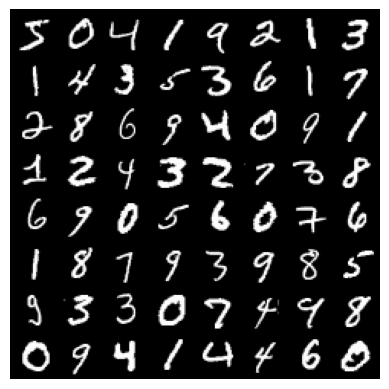

In [6]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Creating models

To define a neural network in pytorch, create a class that inherits from `nn.Module` -> defines the layers of the network in `__init__` function and specify how data will pass through the network in `forward` function

In [89]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f'Using device: {device}')

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same")
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

model = NeuralNetwork(len(classes)).to(device)
print(model)

Using device: cpu
NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [94]:
model = NeuralNetwork(len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, criterion, optimizer):
    model.train()

    size = len(dataloader.dataset)
    running_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        if batch % 100 == 0:
            loss, current = running_loss / (batch + 1), (batch + 1) * len(images)
            print(f'loss: {loss:>4f} [{current:>5d}/{size:>5d}]')

def test(dataloader, model, criterion):
    model.eval()
    
    num_batches = len(dataloader)
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            _, pred = torch.max(output, 1)

            test_loss += loss.item()
            correct += (pred == labels).sum().item()
            total += labels.numel()

    test_loss /= num_batches
    correct /= total
    print(f'Test error: \n\tAccuracy: {correct:.4f}, avg_loss: {test_loss:.4f}')

In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------")
    train(train_loader, model, criterion, optimizer)
    test(test_loader, model, criterion)

Epoch 1
-------------------------
loss: 2.328449 [   64/60000]
loss: 0.505024 [ 6464/60000]
loss: 0.349073 [12864/60000]
loss: 0.275823 [19264/60000]
loss: 0.231534 [25664/60000]
loss: 0.205972 [32064/60000]
loss: 0.187757 [38464/60000]
loss: 0.173909 [44864/60000]
loss: 0.163494 [51264/60000]
loss: 0.153620 [57664/60000]
Test error: 
	Accuracy: 0.9852, avg_loss: 0.0441
Epoch 2
-------------------------
loss: 0.038401 [   64/60000]
loss: 0.073745 [ 6464/60000]
loss: 0.070298 [12864/60000]
loss: 0.065570 [19264/60000]
loss: 0.061054 [25664/60000]
loss: 0.061633 [32064/60000]
loss: 0.061439 [38464/60000]
loss: 0.061137 [44864/60000]
loss: 0.061005 [51264/60000]
loss: 0.060306 [57664/60000]
Test error: 
	Accuracy: 0.9899, avg_loss: 0.0301


In [117]:
# save models
torch.save(model, "model.pt")
torch.save(model.state_dict(), "model_weights.pt")

# load models
m1 = torch.load("model.pt", device, weights_only=False)

m2 = NeuralNetwork(len(classes)).to(device)
m2.load_state_dict(torch.load("model_weights.pt", weights_only=True))

<All keys matched successfully>

In [118]:
# random image
img = torch.randn(1, 28, 28)
img = img.unsqueeze(0).to(device)
img.shape

torch.Size([1, 1, 28, 28])

In [126]:
model.eval()
with torch.no_grad():
    out = model(img)

m1.eval()
with torch.no_grad():
    out1 = m1(img)

m2.eval()
with torch.no_grad():
    out2 = m2(img)

In [129]:
out == out1, out1 == out2

(tensor([[True, True, True, True, True, True, True, True, True, True]]),
 tensor([[True, True, True, True, True, True, True, True, True, True]]))